## 3.3.4 Challenge - ridge and lasso regression

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import math
import statsmodels.api as sm

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data import and cleaning

In [2]:
path = ("/Users/gemma/Documents/data science/DS bootcamp/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv"
            )
df = pd.read_csv(path, delimiter= ',', encoding='latin-1',header=0)


In [3]:
# getting names of columns to access them more easily
# and renaming murder because the name is messy

colnames = df.columns.values
print(colnames)

['City' 'Population' 'Violent\ncrime'
 'Murder and\nnonnegligent\nmanslaughter' 'Rape\n(revised\ndefinition)1'
 'Rape\n(legacy\ndefinition)2' 'Robbery' 'Aggravated\nassault'
 'Property\ncrime' 'Burglary' 'Larceny-\ntheft' 'Motor\nvehicle\ntheft'
 'Arson3']


In [4]:
df.isnull().sum()

City                                        0
Population                                  3
Violent\ncrime                              3
Murder and\nnonnegligent\nmanslaughter      3
Rape\n(revised\ndefinition)1              351
Rape\n(legacy\ndefinition)2                 3
Robbery                                     3
Aggravated\nassault                         3
Property\ncrime                             3
Burglary                                    3
Larceny-\ntheft                             3
Motor\nvehicle\ntheft                       3
Arson3                                    164
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 13 columns):
City                                    351 non-null object
Population                              348 non-null object
Violent
crime                           348 non-null object
Murder and
nonnegligent
manslaughter    348 non-null float64
Rape
(revised
definition)1              0 non-null float64
Rape
(legacy
definition)2               348 non-null object
Robbery                                 348 non-null object
Aggravated
assault                      348 non-null object
Property
crime                          348 non-null object
Burglary                                348 non-null object
Larceny-
theft                          348 non-null object
Motor
vehicle
theft                     348 non-null object
Arson3                                  187 non-null float64
dtypes: float64(3), object(10)
memory usage: 35.7+ KB


In [6]:
df.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [7]:
df.iloc[347:351,:]

df = df.drop([348, 349,350])

In [8]:
# cleaning up population and property crime 

num_cleanup = []

for col in colnames[1:4]:
    num_cleanup.append(col)

for col in colnames[5:12]:
    num_cleanup.append(col)

# there's at least one cell (in Population) with just a space, so filling blanks with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# now dropping the row(s) that contain(s) the nan 
# df.dropna(axis=0, how='any', inplace=True)

# dropping commas and making integers

def cleanup(data_fr, numeric_str):
    # getting rid of commas
    data_fr[numeric_str] = data_fr[numeric_str].apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))

    # finally! the series is an integer (checked in the cell below)
    data_fr[numeric_str] = data_fr[numeric_str].astype(int)
    
    return

for one in num_cleanup:
    cleanup(df, one)

# double checking
df.dtypes


City                                       object
Population                                  int64
Violent\ncrime                              int64
Murder and\nnonnegligent\nmanslaughter      int64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                 int64
Robbery                                     int64
Aggravated\nassault                         int64
Property\ncrime                             int64
Burglary                                    int64
Larceny-\ntheft                             int64
Motor\nvehicle\ntheft                       int64
Arson3                                    float64
dtype: object

In [9]:
# when generating the decision tree, i was getting an error w/ value 1,112

np.where(df.applymap(lambda x: x == '1,112'))

# just going to manually change it since its just 1
df.iloc[216,5] = 1112

# double checking
df.iloc[216,5]

1112

In [10]:
df.head(3)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0.0


In [11]:
df['Arson3'].fillna(value=0, inplace=True)

df['Arson3'].unique()

array([  0.,   3.,   1.,   2.,  10.,   4.,   5.,   8.,   6.,  15.,  22.,
       132.,  57.])

In [12]:
df.drop(labels=['Rape\n(revised\ndefinition)1'], axis=1, inplace=True)


In [13]:
df.head(3)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.0
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.0


### Features

In [14]:
#df['Any_theft'] = np.where( (df['Robbery']==0 | df['Burglary']==0) , 0, 1)

df['Any_theft'] = '1'
df.loc[(df['Burglary'] == 0) & (df['Larceny-\ntheft'] == 0) & (df['Robbery'] == 0)  & (df['Motor\nvehicle\ntheft'] == 0), 'Any_theft'] = '0'

#df['Sum'] = 0

new_colnames = df.columns.values
new_colnames = new_colnames[2:]

# sum all cols
#df['sum'] = df[df.columns].sum(axis=1)

df['sum'] = df[new_colnames].sum(axis=1)

In [15]:
df.head(3)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Any_theft,sum
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.0,1,24.0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.0,1,54.0
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.0,1,38.0


In [16]:
df['Murder_binary'] = np.where(df[colnames[3]]==0, 0, 1)
df['Robbery_binary'] = np.where(df['Robbery'] == 0, 0, 1)
df['Aggravated_asault_binary'] = np.where(df['Aggravated\nassault'] == 0,0,1)

In [17]:
df.head(3)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Any_theft,sum,Murder_binary,Robbery_binary,Aggravated_asault_binary
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.0,1,24.0,0,0,0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.0,1,54.0,0,0,1
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.0,1,38.0,0,0,1


In [18]:
df['Arson3_binary'] = np.where(df['Arson3']==0, 0, 1)

In [19]:
df['log_of_Pop'] = np.log(df['Population'])

## Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


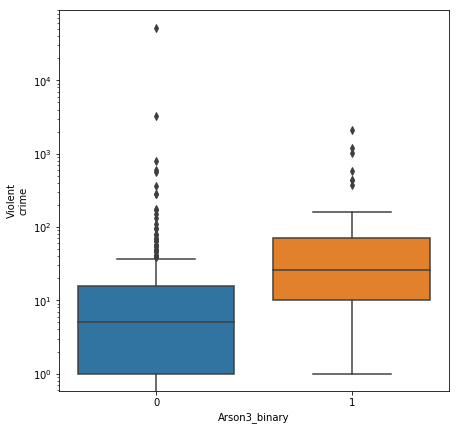

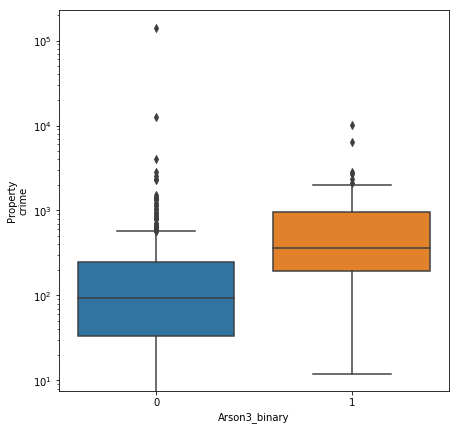

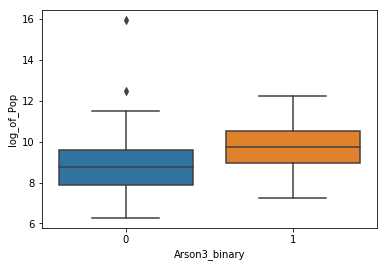

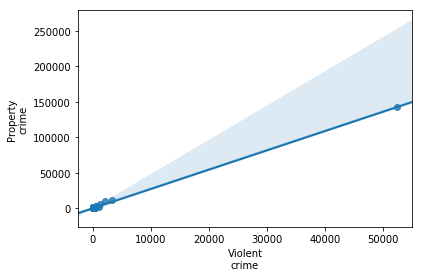

In [20]:
# Bivariate relationships of predictors to Arson binary...

f, ax = plt.subplots(figsize=(7, 7))
ax.set( yscale="log")
sns.boxplot(x="Arson3_binary", y='Violent\ncrime', data=df)  
plt.show()

f, ax = plt.subplots(figsize=(7, 7))
ax.set( yscale="log")
sns.boxplot(x="Arson3_binary", y='Property\ncrime', data=df)
plt.show()

sns.boxplot(x="Arson3_binary", y='log_of_Pop', data=df)
plt.show()

# Relationship between predictors.
sns.regplot(x='Violent\ncrime', y='Property\ncrime', data=df)
plt.show()

In [21]:
new_colnames = df.columns.values
new_colnames = new_colnames[1:]

print(new_colnames)

['Population' 'Violent\ncrime' 'Murder and\nnonnegligent\nmanslaughter'
 'Rape\n(legacy\ndefinition)2' 'Robbery' 'Aggravated\nassault'
 'Property\ncrime' 'Burglary' 'Larceny-\ntheft' 'Motor\nvehicle\ntheft'
 'Arson3' 'Any_theft' 'sum' 'Murder_binary' 'Robbery_binary'
 'Aggravated_asault_binary' 'Arson3_binary' 'log_of_Pop']


In [22]:
# Declare predictors.

# these ones conf intervals cross 0: 'Population','Violent\ncrime','Property\ncrime',

X_statsmod = df[['sum','Murder_binary', 'Robbery_binary','Aggravated_asault_binary', 
                 'log_of_Pop']]
#X_statsmod = df.drop(labels=['City','Arson3', 'Any_theft', ], axis=1)

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_statsmod['intercept'] = 1 

# Declare and fit the model.
logit = sm.Logit(df['Arson3_binary'], X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
#print(result.summary())

result.summary()

Optimization terminated successfully.
         Current function value: 0.366938
         Iterations 27


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


LinAlgError: Singular matrix

In [23]:
result.conf_int()

NameError: name 'result' is not defined

In [24]:
df['Arson3_binary'].unique()

df.dtypes

City                                       object
Population                                  int64
Violent\ncrime                              int64
Murder and\nnonnegligent\nmanslaughter      int64
Rape\n(legacy\ndefinition)2                 int64
Robbery                                     int64
Aggravated\nassault                         int64
Property\ncrime                             int64
Burglary                                    int64
Larceny-\ntheft                             int64
Motor\nvehicle\ntheft                       int64
Arson3                                    float64
Any_theft                                  object
sum                                       float64
Murder_binary                               int64
Robbery_binary                              int64
Aggravated_asault_binary                    int64
Arson3_binary                               int64
log_of_Pop                                float64
dtype: object

In [25]:
df.corr()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,sum,Murder_binary,Robbery_binary,Aggravated_asault_binary,Arson3_binary,log_of_Pop
Population,1.000000,0.998854,0.986758,0.990839,0.998469,0.999134,0.996265,0.970578,0.997946,0.992421,0.023680,0.997282,0.162309,0.064371,0.039212,-0.006565,0.343233
Violent\ncrime,0.998854,1.000000,0.992098,0.994985,0.999923,0.999942,0.998059,0.978150,0.998762,0.996271,0.040651,0.998938,0.165904,0.057714,0.034630,-0.008656,0.333983
Murder and\nnonnegligent\nmanslaughter,0.986758,0.992098,1.000000,0.997746,0.993104,0.990843,0.995403,0.993733,0.993175,0.997992,0.128936,0.994996,0.211661,0.069557,0.041453,0.007569,0.363573
Rape\n(legacy\ndefinition)2,0.990839,0.994985,0.997746,1.000000,0.995438,0.994140,0.997843,0.992442,0.996260,0.998764,0.093916,0.997507,0.201359,0.076546,0.045809,0.005431,0.368530
Robbery,0.998469,0.999923,0.993104,0.995438,1.000000,0.999742,0.998237,0.979525,0.998735,0.996927,0.046528,0.999056,0.166483,0.057747,0.034157,-0.008254,0.334905
Aggravated\nassault,0.999134,0.999942,0.990843,0.994140,0.999742,1.000000,0.997622,0.976288,0.998561,0.995403,0.034251,0.998593,0.163747,0.056878,0.034434,-0.009569,0.331762
Property\ncrime,0.996265,0.998059,0.995403,0.997843,0.998237,0.997622,1.000000,0.987137,0.999666,0.998302,0.076784,0.999868,0.190670,0.079318,0.047844,0.007561,0.369574
Burglary,0.970578,0.978150,0.993733,0.992442,0.979525,0.976288,0.987137,1.000000,0.982700,0.991464,0.174057,0.985244,0.240979,0.098352,0.060181,0.032215,0.411333
Larceny-\ntheft,0.997946,0.998762,0.993175,0.996260,0.998735,0.998561,0.999666,0.982700,1.000000,0.996878,0.061608,0.999790,0.182823,0.076913,0.046281,0.004017,0.363017
Motor\nvehicle\ntheft,0.992421,0.996271,0.997992,0.998764,0.996927,0.995403,0.998302,0.991464,0.996878,1.000000,0.089692,0.998183,0.191807,0.070604,0.042391,0.006523,0.363503


In [26]:
from sklearn.linear_model import LogisticRegression

# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lr = LogisticRegression(C=1e9)
y = df['Arson3_binary']
#X = df[['log_of_Pop', 'gre']]
X = df.drop(labels=['City','Arson3'], axis=1)

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print('\n Accuracy by Arson')
print(pd.crosstab(pred_y_sklearn, y))

print('\n Percentage accuracy')
print(lr.score(X, y))

Coefficients
[[-1.36336706e-05 -7.44933039e-03 -2.76630722e-03 -5.00761118e-03
  -2.22088987e-03  5.58013894e-05 -3.91408573e-03 -6.97287854e-03
  -3.73242644e-03  6.79121925e-03 -9.87706953e-03  4.13178448e-03
   2.33342381e-04 -3.66410525e-03 -6.43561835e-03  5.15318424e-03
  -8.20230460e-02]]
[-0.01024167]

 Accuracy by Arson
Arson3_binary    0   1
row_0                 
0              293  53
1                1   1

 Percentage accuracy
0.8448275862068966


In [27]:
from sklearn.model_selection import train_test_split

# w/ holdout groups
target2 = df['Arson3_binary']
data2 = df[['sum','Murder_binary', 'Robbery_binary','Aggravated_asault_binary', 
                 'log_of_Pop']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=20)

print('With 20% Holdout: ' + str(lr.fit(X_train2, y_train2).score(X_test2, y_test2)))
print('Testing on Sample: ' + str(lr.fit(data2, target2).score(data2, target2)))



With 20% Holdout: 0.8714285714285714
Testing on Sample: 0.8448275862068966


In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(lr, data2, target2, cv=10)


array([0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.85294118,
       0.85294118, 0.82352941, 0.85294118, 0.85294118, 0.85294118])

## Ridge Regression

In [29]:
# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.drop(columns='City').iloc[trainsize:, :].copy()
df_train = df.drop(columns='City').iloc[:trainsize, :].copy()

# Set up the regression model to predict defaults using all other
# variables as features.
regr1 = linear_model.LinearRegression()
Y_train = df_train['Arson3_binary'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['Arson3_binary'])]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

Y_test = df_test['Arson3_binary'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['Arson3_binary'])]

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. 

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))



R-squared simple model:
0.5489463506800005
0.5420334169151506


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [30]:
cross_val_score(ridgeregr, data2, target2, cv=10)

array([ 1.62076233e-02, -7.67912026e-03, -1.74959992e-02,  7.76344091e-02,
        8.22330039e-02,  9.63929542e-02, -8.60165563e+00,  1.76463123e-01,
       -6.20170833e-02,  1.09675171e-01])

In [31]:
print('With 20% Holdout: ' + str(ridgeregr.fit(X_train2, y_train2).score(X_test2, y_test2)))
print('Testing on Sample: ' + str(ridgeregr.fit(data2, target2).score(data2, target2)))

With 20% Holdout: -4.393543528003717
Testing on Sample: 0.08209877019432688


## Lasso Regression

In [32]:
# Small number of parameters.

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['Arson3_binary'])]

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)


R² for the model with many features:
0.08809252840932447

Parameter estimates for the model with many features:
[ 6.78075593e-06  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -8.19198316e-04
 -1.20651631e-05  7.75851435e-05  0.00000000e+00  0.00000000e+00
  3.23257378e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.45180016e-02]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [33]:
cross_val_score(lassBig, data2, target2, cv=10)

array([-2.03414861e-02, -1.55078575e-02, -2.03426750e-02, -3.77947384e-02,
       -2.26478298e-03, -2.03480517e-02, -2.28300018e+01, -2.51990943e-03,
       -1.70678061e-02, -7.05729948e-04])

In [34]:
#print('With 20% Holdout: ' + str(lassBig.fit(X_train2, Y_train).score(X_test2, y_test2)))
print('Testing on Sample: ' + str(lassBig.fit(data2, target2).score(data2, target2)))

Testing on Sample: 1.1216945053571514e-05
